## Midterm 2

In [2]:
%matplotlib inline

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.data import loadlocal_mnist

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings 
warnings.filterwarnings('ignore')

Firstly, I defined some helper functions that I used to create the RBM and to get all images indexes that it doesn't have a match between a prediction and true value. <br>
*sigmoid* allows computing a sigmoid function. <br>
*find_all_occurrences* finds all occurrences between a specific label and its prediction. <br>

In [3]:
'''
sigmoid
args: x - variable to compute the logistic function
'''
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
'''
find_all_occurrences
args: pred_target - class name target in predictions list
      lab_target - class name target in labels list
      predictions - list of predicted item
      labels - list of true label item 
'''
def find_all_occurrences(pred_target, lab_target, predictions, labels):
    res = []
    for i in range(predictions.shape[0]):
        if predictions[i] != pred_target or labels[i] != lab_target:
            continue
        else:
                res.append(i)
    return res          

I created the class RBM that implements a Restricted Boltzmann Machine: <br>
*_init_* is the constructor where it defines the hidden neurons and initializes bias for visible and hidden neurons. In addition, it defines a random weight matrix. <br>
*ph2v* computes the conditional probability on hidden units given the samples of the visible units and it returns the hidden samples. <br>
*pv2h* computes the conditional probability on visible units given the samples of the hidden units and it returns the visible samples. <br>
*gibbs_sampling* runs a Gibbs sampling approach. <br>
*cd_k* performs one step of contrastive divergence. <br>
*fit* fits a model using the contrastive divergence and updates the weight matrix and the two biases. <br>
*show_features* shows the features learned by the model. <br>
*show_reconstruction* shows the reconstruction of a list of images. 

In [5]:
class RBM():
    '''
    __init__
    args: n_visible - number of visible neurons
          n_hidden - number of hidden neurons
          k - order of the Gibbs sampling
    '''
    def __init__(self, n_visible, n_hidden, k=1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = np.random.uniform(-1, 1, (n_hidden, n_visible))
        self.bias_visible = np.zeros(n_visible)
        self.bias_hidden = np.zeros(n_hidden)
        self.k = k
    
    '''
    ph2v
    args: v - samples of the visible units
    '''
    def ph2v(self, v):
        hp = sigmoid(self.bias_hidden + np.dot(v, self.W.T))
        hs = np.random.binomial(1, hp, size=len(hp))
        return hp, hs
    
    '''
    pv2h
    args: h - samples of the hidden units
    '''
    def pv2h(self, h):
        vp = sigmoid(self.bias_visible + np.dot(h, self.W))
        vs = np.random.binomial(1, vp, size=len(vp))
        return vp, vs
    
    '''
    gibbs_sampling
    args: v - samples of the visible units
    '''
    def gibbs_sampling(self, v):
        for i in range(self.k):
            h_probs, h_sample = self.ph2v(v)  
            v_probs, v_sample = self.pv2h(h_sample)                
        return h_probs, h_sample, v_probs, v_sample 
    
    '''
    cd_k
    args: v_samples - training samples visible  
          temp_W - batch weight matrix
          temp_bh - batch hidden bias
          temp_bv - batch visible bias
          index - batch index
          bs - batch size
    '''
    def cd_k(self, v_samples, temp_W, temp_bh, temp_bv, index, bs):
        h_probs_gibbs, h_samples_gibbs, v_probs_gibbs, v_sample_gibbs = self.gibbs_sampling(v_samples)
        h_probs, h_samples = self.ph2v(v_sample_gibbs)

        data = np.outer(h_probs_gibbs, v_samples)
        model = np.outer(h_probs, v_sample_gibbs)

        temp_W[index%bs] = data - model
        temp_bh[index%bs] = h_probs_gibbs - h_probs
        temp_bv[index%bs] = v_samples - v_sample_gibbs
        
        return temp_W, temp_bh, temp_bv
    
    '''
    fit
    args: X - training images 
          epoch - number of epochs
          batch_size - size of batch
          lr - learning rate
    '''
    def fit(self, X, epoch=1, batch_size=5, lr=0.01):        
        n_sample = X.shape[0]       
        size = X.shape[1]
        for e in range(epoch):
            for i in range(0, n_sample, batch_size):
                j = i
                b_W = np.zeros((batch_size, self.n_hidden, self.n_visible))
                b_bh = np.zeros((batch_size, self.n_hidden))
                b_bv = np.zeros((batch_size, self.n_visible))
                while j < n_sample and j-i < batch_size:
                    v_samples = X[j]
                    #perform contrastive divergence
                    b_W, b_bh, b_bv = self.cd_k(v_samples, b_W, b_bh, b_bv, j, batch_size)
                    j+=1

                # average gradient computed on a mini-batch
                delta_W = np.mean(b_W, axis=0)
                delta_bh = np.mean(b_bh, axis=0)
                delta_bv = np.mean(b_bv, axis=0)
                
                #update weight matrix and biases
                self.W += lr*(delta_W) 
                self.bias_visible += lr*(delta_bv)
                self.bias_hidden += lr*(delta_bh)
                                     
    def show_features(self):
        max_w = np.amax(self.W)
        min_w = np.amin(self.W)
        ncols = 10
        nrows = 6
        fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))
        ind = 0
        for i in range(nrows):
            for j in range(ncols):
                x = self.W[ind]
                x = (x.reshape(1, -1) - min_w)/max_w
                ax[i, j].imshow(x.reshape(28,28))
                ax[i, j].set_axis_off()
                ind = ind + 1
                
        fig.suptitle('RBM Features', size=20)
        fig.tight_layout()         
        plt.show()
        
    '''
    show_reconstruction
    args: imgs - list of the images to reconstruct
          indexes - list of pointers of the images to reconstruct
    '''    
    def show_reconstruction(self, imgs, indexes):
        ncol = 10 
        nrow = int(len(indexes) /ncol)
        
        fig_original, ax_original = plt.subplots(nrow, ncol, figsize=(10, 10))
        ind = 0
        for i in range(nrow):    
            for j in range(ncol):
                ax_original[i, j].imshow(np.reshape(imgs[indexes[ind]], newshape=(28, 28)))
                ax_original[i, j].set_axis_off()
                ax_original[i, j].set_aspect('equal')
                ind = ind + 1
        
        fig_original.suptitle('Original images', size=20)
        fig_original.tight_layout()
        fig_original.subplots_adjust(wspace=0, hspace=0)
        fig_original.show()
        
        fig_reconstruct, ax_reconstruct = plt.subplots(nrow, ncol, figsize=(10, 10))
        ind = 0  
        for i in range(nrow):
            for j in range(ncol):
                h_probs, h_sample = self.ph2v(imgs[indexes[ind]])
                v_probs, v_sample = self.pv2h(h_probs) 
                ax_reconstruct[i, j].imshow(np.reshape(v_probs, newshape=(28, 28)))
                ax_reconstruct[i, j].set_axis_off()
                ax_reconstruct[i, j].set_aspect('equal')
                ind = ind + 1
            
        fig_reconstruct.suptitle('Reconstructed images', size=20) 
        fig_reconstruct.tight_layout()
        fig_reconstruct.subplots_adjust(wspace=0, hspace=0)
        fig_reconstruct.show()

After that, I loaded the MNIST training dataset using a utility function that loads the MNIST dataset from byte-form into NumPy arrays. Each feature vector consists of 784 pixels (28x28 pixels images).

In [6]:
#load mnist training dataset
X_train, y_train = loadlocal_mnist(
        images_path='mnist/train-images.idx3-ubyte', 
        labels_path='mnist/train-labels.idx1-ubyte')

Then, I normalized the entire train dataset with a MinMaxScaler because we should normalize our data between [0,1] with an RBM.

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

I create an instance of RBM with __75__ hidden units and I trained it using __10__ epochs, batch size equal to __10__ and learning rate equal to __0.1__.

In [8]:
rbm_75 = RBM(X_train.shape[1], 75)
rbm_75.fit(X_train, epoch=10, batch_size=10, lr=0.1)

This function shows the RBM features that represent the columns of the weight matrix *W*. Each column represents one mode of interaction between the pixels, where pixels of the same shade were identified by the RBM.
In these results below, some of the modes of interactions that the RBM detected resemble specific digits. Since we know that the dataset actually contains distinct digits, this is strong attested to the algorithm’s ability to detect repeating patterns in its input vectors.

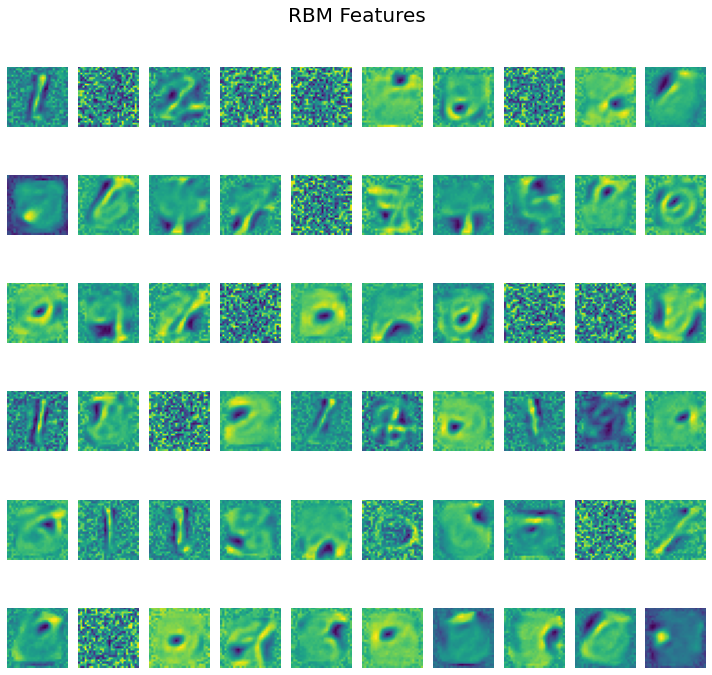

In [9]:
rbm_75.show_features()

In this part, I encoded the training and test dataset. In addition, to improve the performance I applied one-hot encoding on training labels.

In [10]:
#encoding train set images
encoded_X_train = np.zeros((X_train.shape[0], rbm_75.n_hidden))
encoded_y_train = np.zeros((X_train.shape[0], 10))

for i in range(X_train.shape[0]):
    _, _, _, v_samples_gibbs = rbm_75.gibbs_sampling(X_train[i])
    h_probs, h_samples = rbm_75.ph2v(v_samples_gibbs)
    encoded_X_train[i] = h_samples
    encoded_y_train[i][y_train[i]] = 1 #one hot encoding 

In [11]:
#load mnist test dataset
X_test, y_test = loadlocal_mnist(
        images_path='mnist/t10k-images.idx3-ubyte', 
        labels_path='mnist/t10k-labels.idx1-ubyte')

X_test = scaler.fit_transform(X_test)

In [12]:
#encoding test set images
encoded_X_test = np.zeros((X_test.shape[0], rbm_75.n_hidden))

for i in range(X_test.shape[0]):
    _, _, _, v_samples_gibbs = rbm_75.gibbs_sampling(X_test[i])
    h_probs, h_samples = rbm_75.ph2v(v_samples_gibbs)
    encoded_X_test[i] = h_samples

In this section, I created a simple classifier to recognize the MNIST digits using as inputs the images encoded previously with RBM. The classifier has two layers with respectively __35__ and __10__ units using __relu__ and __softmax__ activation functions.

In [13]:
model = Sequential()
model.add(Dense(35, activation="relu", input_shape=(rbm_75.n_hidden,)))
model.add(Dense(10, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(encoded_X_train, encoded_y_train, batch_size=10, epochs=13, validation_split=0.1, verbose=1)

Epoch 1/13
5400/5400 [==============================] - 14s 2ms/step - loss: 0.5058 - accuracy: 0.8500 - val_loss: 0.3106 - val_accuracy: 0.9052
Epoch 2/13
5400/5400 [==============================] - 7s 1ms/step - loss: 0.3540 - accuracy: 0.8899 - val_loss: 0.2813 - val_accuracy: 0.9147
Epoch 3/13
5400/5400 [==============================] - 7s 1ms/step - loss: 0.3220 - accuracy: 0.8990 - val_loss: 0.2620 - val_accuracy: 0.9192
Epoch 4/13
5400/5400 [==============================] - 12s 2ms/step - loss: 0.3029 - accuracy: 0.9035 - val_loss: 0.2543 - val_accuracy: 0.9240
Epoch 5/13
5400/5400 [==============================] - 7s 1ms/step - loss: 0.2893 - accuracy: 0.9075 - val_loss: 0.2457 - val_accuracy: 0.9263
Epoch 6/13
5400/5400 [==============================] - 7s 1ms/step - loss: 0.2803 - accuracy: 0.9099 - val_loss: 0.2403 - val_accuracy: 0.9282
Epoch 7/13
5400/5400 [==============================] - 14s 3ms/step - loss: 0.2738 - accuracy: 0.9119 - val_loss: 0.2414 - val_accura

Training the classifier, I achieved quite good results with this RBM. I got approximately 0.93 on validation accuracy.

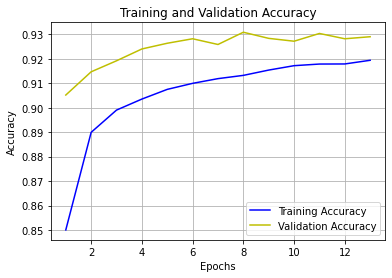

In [14]:
# Show training results
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

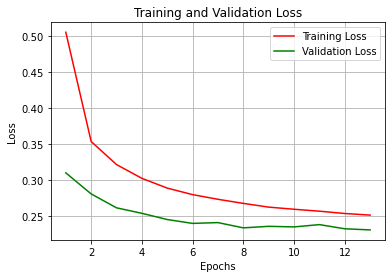

In [15]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [16]:
y_pred_test = np.argmax(model.predict(encoded_X_test),axis=1)

In general, the confusion matrix shows good results because there are many correct predictions. But, we can see there are many classification errors, especially on __9__, __7__, __3__, and so on. From this matrix, we notice that __4__ has not had a bad classification, but it has many incorrect predictions with the __9__ label. Same with __0__ that it has some incorrect predictions on __6__ label.

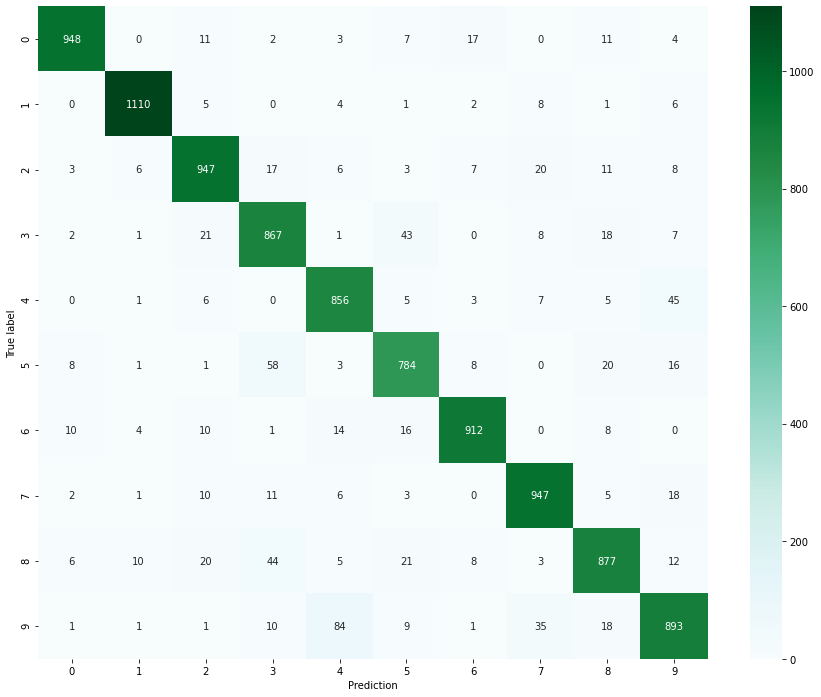

In [17]:
cf_matrix = confusion_matrix(y_pred_test, y_test)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("True label")
plt.show()

This report confirms the previous confusion matrix; indeed we can notice that, for example, there is a bit lower f1-score on __8__, __5__, and so on. In this case, the classification returns an accuracy of approximately __0.92__.

In [18]:
print(classification_report(y_pred_test, y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9673    0.9452    0.9561      1003
           1     0.9780    0.9763    0.9771      1137
           2     0.9176    0.9212    0.9194      1028
           3     0.8584    0.8957    0.8766       968
           4     0.8717    0.9224    0.8963       928
           5     0.8789    0.8721    0.8755       899
           6     0.9520    0.9354    0.9436       975
           7     0.9212    0.9442    0.9325      1003
           8     0.9004    0.8718    0.8859      1006
           9     0.8850    0.8481    0.8661      1053

    accuracy                         0.9141     10000
   macro avg     0.9131    0.9132    0.9129     10000
weighted avg     0.9145    0.9141    0.9141     10000



In this part, I showed the differences between the original images and the incorrect prediction reconstructed. We can notice the RBM reconstructs some digits erronously, indeed we can see some __7__ that seems a __9__ digit.

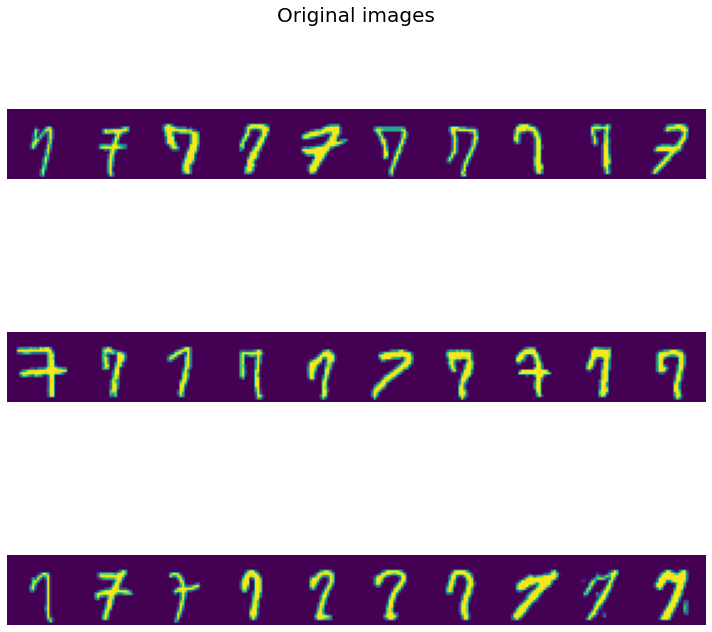

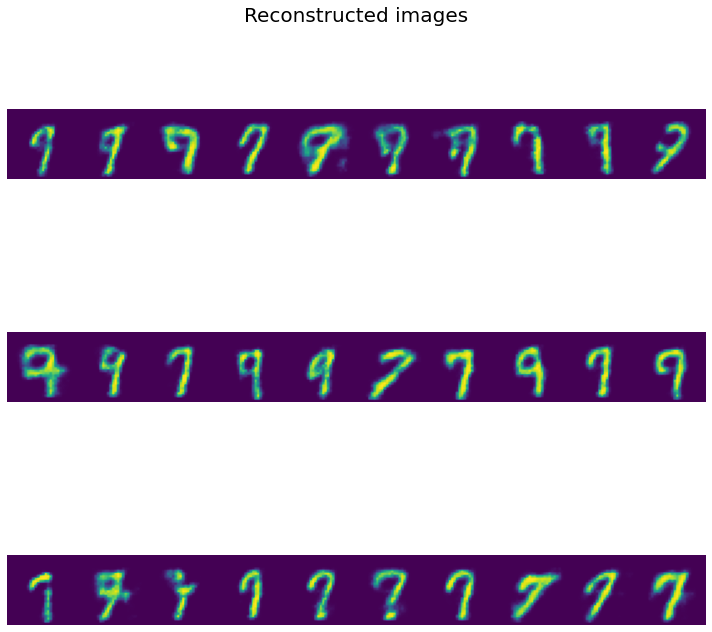

In [19]:
img_recs = find_all_occurrences(9, 7, y_pred_test, y_test)
rbm_75.show_reconstruction(X_test, img_recs)

In this case, the reconstruction of digits does not seem too bad, indeed the classifier has some difficulties recognizing the __9__ with __4__ digit.

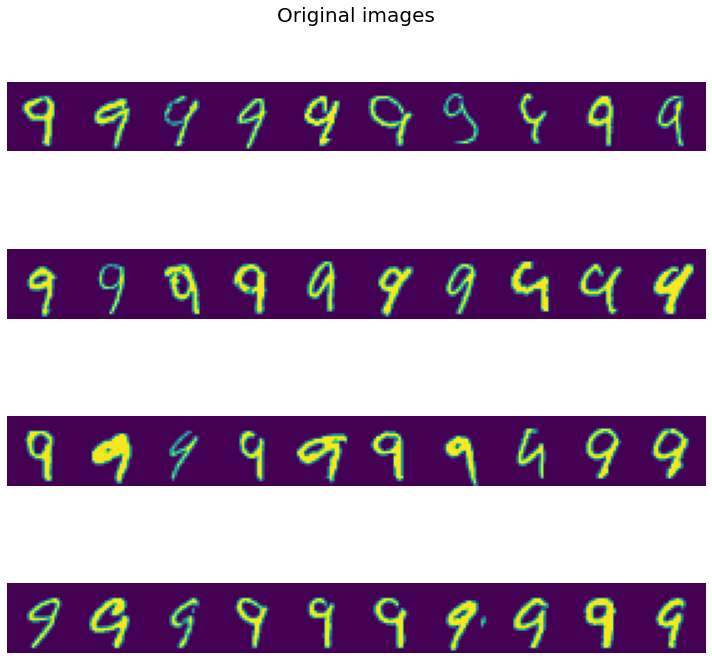

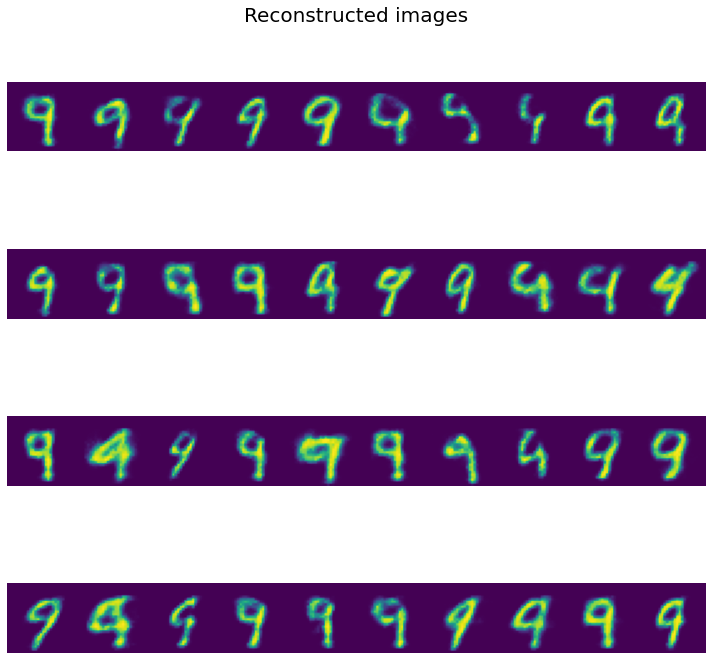

In [20]:
img_recs = find_all_occurrences(4, 9, y_pred_test, y_test)
rbm_75.show_reconstruction(X_test, img_recs)

Here we can notice again the same problem found with __7__ digits, i.e. the RBM reconstructs some __3__ in __5__ digits.

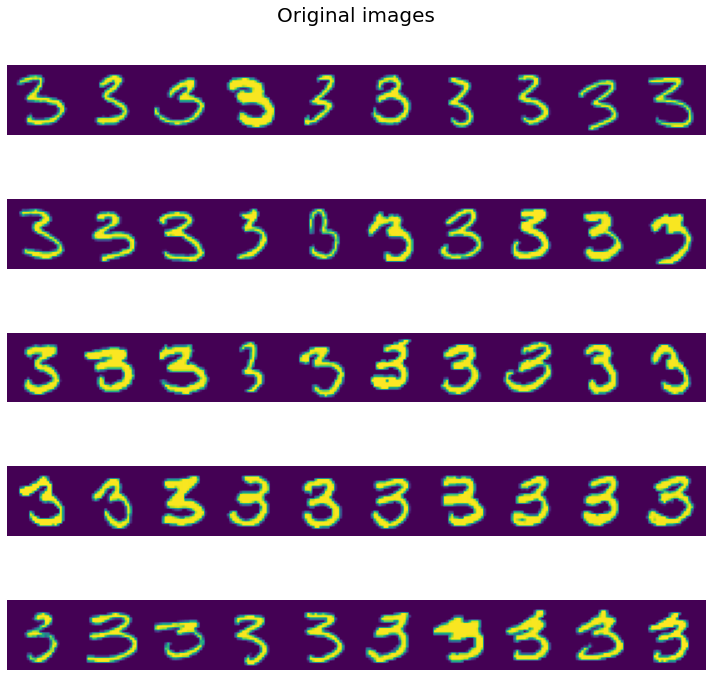

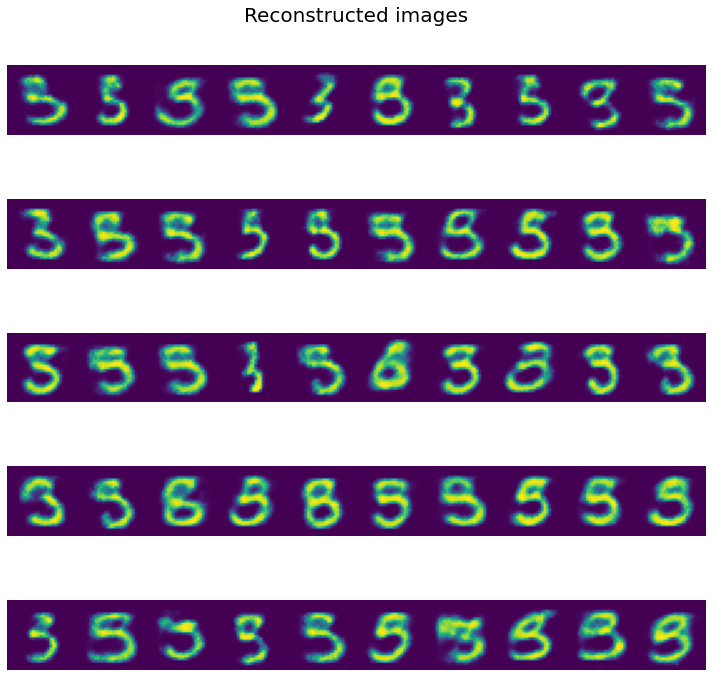

In [21]:
img_recs = find_all_occurrences(5, 3, y_pred_test, y_test)
rbm_75.show_reconstruction(X_test, img_recs)

In this part, I create a new instance of an RBM to compare if there are some differences between the two instances in terms of performance. <br>
Indeed this time, I create an RBM with __100__ hidden units and I trained it using __10__ epochs, batch size equal to __1__, and learning rate equal to __0.01__.

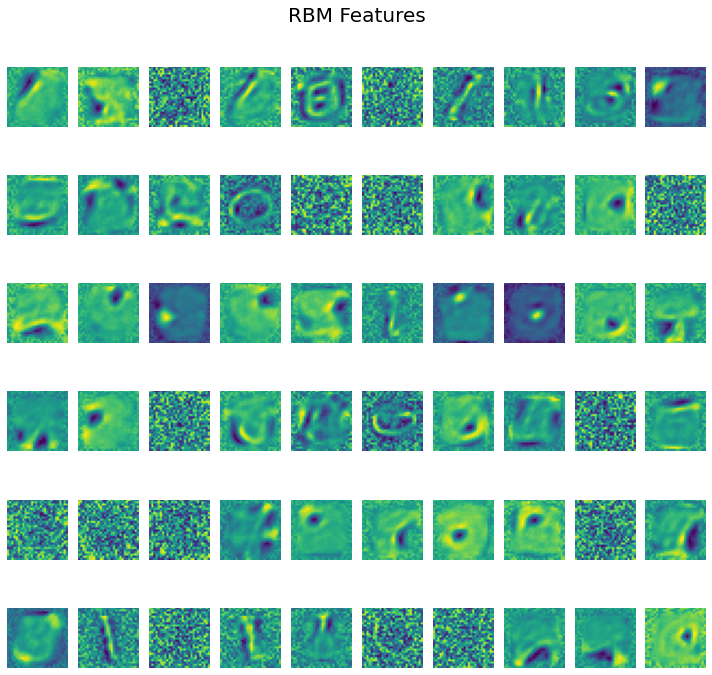

In [22]:
rbm_100 = RBM(X_train.shape[1], 100)
rbm_100.fit(X_train, epoch=10, batch_size=1, lr=0.01)
rbm_100.show_features()

In [23]:
#encoding train set images
encoded_X_train = np.zeros((X_train.shape[0], rbm_100.n_hidden))
encoded_y_train = np.zeros((X_train.shape[0], 10))

for i in range(X_train.shape[0]):
    _, _, _, v_samples_gibbs = rbm_100.gibbs_sampling(X_train[i])
    h_probs, h_samples = rbm_100.ph2v(v_samples_gibbs)
    encoded_X_train[i] = h_samples
    encoded_y_train[i][y_train[i]] = 1 #one hot encoding 

#encoding test set images
encoded_X_test = np.zeros((X_test.shape[0], rbm_100.n_hidden))

for i in range(X_test.shape[0]):
    _, _, _, v_samples_gibbs = rbm_100.gibbs_sampling(X_test[i])
    h_probs, h_samples = rbm_100.ph2v(v_samples_gibbs)
    encoded_X_test[i] = h_samples

model = Sequential()
model.add(Dense(35, activation="relu", input_shape=(rbm_100.n_hidden,)))
model.add(Dense(10, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(encoded_X_train, encoded_y_train, batch_size=10, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
5400/5400 [==============================] - 8s 1ms/step - loss: 0.4699 - accuracy: 0.8586 - val_loss: 0.2711 - val_accuracy: 0.9205
Epoch 2/10
5400/5400 [==============================] - 8s 1ms/step - loss: 0.3260 - accuracy: 0.8989 - val_loss: 0.2451 - val_accuracy: 0.9260
Epoch 3/10
5400/5400 [==============================] - 8s 2ms/step - loss: 0.2952 - accuracy: 0.9088 - val_loss: 0.2312 - val_accuracy: 0.9267
Epoch 4/10
5400/5400 [==============================] - 8s 2ms/step - loss: 0.2744 - accuracy: 0.9135 - val_loss: 0.2187 - val_accuracy: 0.9315
Epoch 5/10
5400/5400 [==============================] - 7s 1ms/step - loss: 0.2607 - accuracy: 0.9190 - val_loss: 0.2124 - val_accuracy: 0.9307
Epoch 6/10
5400/5400 [==============================] - 8s 1ms/step - loss: 0.2511 - accuracy: 0.9205 - val_loss: 0.2150 - val_accuracy: 0.9315
Epoch 7/10
5400/5400 [==============================] - 7s 1ms/step - loss: 0.2434 - accuracy: 0.9236 - val_loss: 0.2042 - val_accuracy:

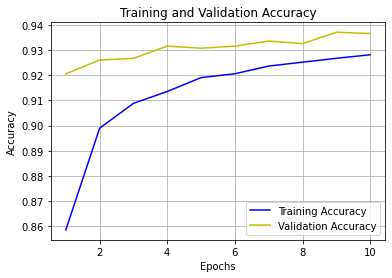

In [24]:
# Show training results
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

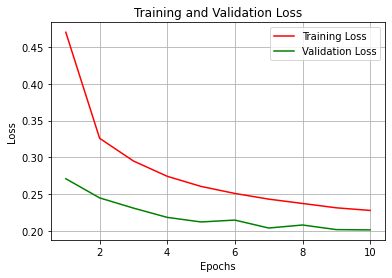

In [25]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In this case, we notice that there is a slight improvement on some predicted labels, but we can see a very slightly worsening in some predictions such as __9__ and __6__.

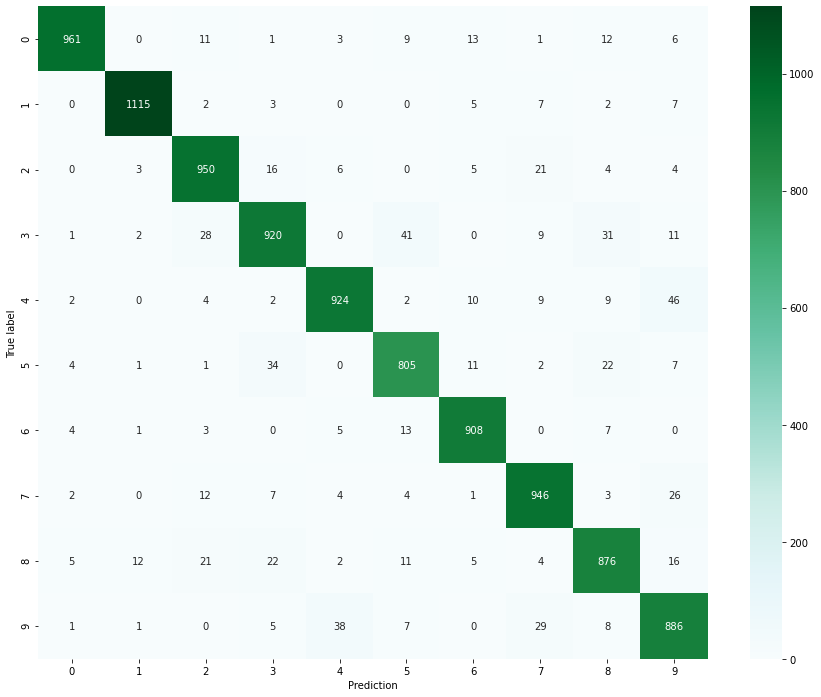

In [26]:
y_pred_test = np.argmax(model.predict(encoded_X_test),axis=1)
cf_matrix = confusion_matrix(y_pred_test, y_test)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("True label")
plt.show()

The classification report shows a slightly better accuracy with respect to the RBM with 75 units.

In [27]:
print(classification_report(y_pred_test, y_test, digits=4))

              precision    recall  f1-score   support

           0     0.9806    0.9449    0.9624      1017
           1     0.9824    0.9772    0.9798      1141
           2     0.9205    0.9415    0.9309      1009
           3     0.9109    0.8821    0.8962      1043
           4     0.9409    0.9167    0.9286      1008
           5     0.9025    0.9076    0.9050       887
           6     0.9478    0.9649    0.9563       941
           7     0.9202    0.9413    0.9306      1005
           8     0.8994    0.8994    0.8994       974
           9     0.8781    0.9087    0.8931       975

    accuracy                         0.9291     10000
   macro avg     0.9283    0.9284    0.9283     10000
weighted avg     0.9295    0.9291    0.9292     10000



### Considerations

The restricted Boltzmann Machine is an algorithm that it allows, for this problem, a way to learn features. The RBM was trained on the MNIST dataset thus it needs to learn the digits' features. After that, I encoded all training and test images to classify them. <br>
In the analysis, we can notice that the RBM found some difficulties to reconstruct some digits such as 7 and 3, but in general, the algorithm works well.
I tested with different numbers of neurons: using a low number of units, the RBM will have an underfitting case then it will encode the dataset with poor quality; on the contrary, if we set a higher number of units it will have an overfitting problem. <br>
Some valuable improvements that could be applied are: implementing a decay for learning rate and weight decay. In addition, applying a convolutional RBM could improve the entire algorithm.